In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import yfinance as yf
from datetime import date, timedelta
from statsmodels.tsa.stattools import adfuller

In [7]:
today = date.today()
end_date = today.strftime("%Y-%m-%d")

interval = "1h"
interval_map = {
    "1m": timedelta(minutes=60*24*7),
    "1h": timedelta(hours=24*90),
    "1d": timedelta(days=365*1),   
}

start_date = (today - interval_map[interval]).strftime("%Y-%m-%d")

ticker1 = "BZ=F"
ticker2 = "CL=F"
df1 = yf.download(ticker1, start=start_date, end=end_date, interval=interval)
df2 = yf.download(ticker2, start=start_date, end=end_date, interval=interval)

# Use common index to align dates.
df = pd.DataFrame(index=df1.index)


colname = "Adj Close"
df["S1"] = df1[colname]
df["S2"] = df2[colname]

df.index = pd.to_datetime(df.index)

# Drop missing entries
df.dropna(inplace=True)

df.tail()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,S1,S2
2022-11-03 14:00:00-04:00,94.779999,88.250000
2022-11-03 15:00:00-04:00,94.639999,88.080002
2022-11-03 16:00:00-04:00,94.440002,87.949997
2022-11-03 18:00:00-04:00,94.489998,87.959999
2022-11-03 19:00:00-04:00,94.570000,88.029999


S1    0.932033
dtype: float64


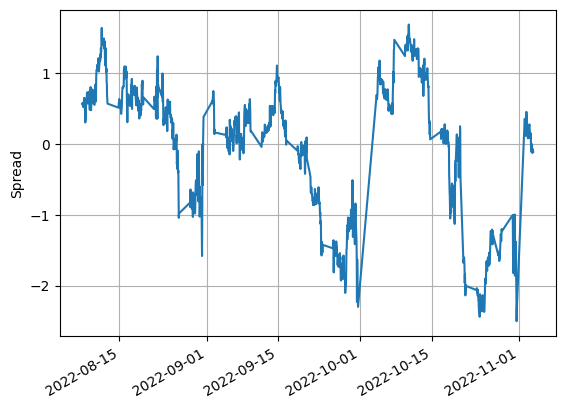

In [33]:
# Note: X,y this way around is consistent with plotting S1 on horizontal axis and S2 on vertical by default.

# Dependent variable.
X = df["S1"]

# Prepend a column of 1.0s to the df for y.
# y = sm.add_constant(df["S2"])
y = df["S2"]

# Endog = response/dependent variable, explained by the model.
model = sm.OLS(endog=y, exog=X)
res = model.fit()

print(res.params)
beta = res.params[0]

# Note that this is the other way around compared to other notebooks - ratify.
df["spread"] = df["S2"] - beta * df["S1"]
df["spread"].plot()
plt.grid()
plt.ylabel("Spread")
plt.show()

S2    1.072792
dtype: float64


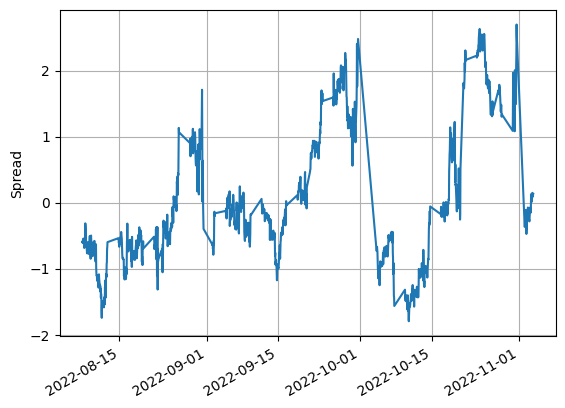

In [32]:
# Note: X,y this way around is more intuitive to look at the df and at MR notebooks. But keep in mind when plotting S1 will be on the
# horizontal axis and S2 on vertical by default. Therefore the gradient would be 1/beta/

# Dependent variable.
X = df["S2"]

# Prepend a column of 1.0s to the df for y.
# y = sm.add_constant(df["S2"])
y = df["S1"]

# Endog = response/dependent variable, explained by the model.
model = sm.OLS(endog=y, exog=X)
res = model.fit()

print(res.params)
beta = res.params[0]

# Note that this is the right way around compared to other notebooks.
df["spread"] = df["S1"] - beta * df["S2"]
df["spread"].plot()
plt.grid()
plt.ylabel("Spread")
plt.show()

In [34]:
adf = adfuller(df["spread"], maxlag=1)
adf

(-3.052723848077549,
 0.03025547704504262,
 1,
 1278,
 {'1%': -3.4354771386691763,
  '5%': -2.8638041921002126,
  '10%': -2.5679754757164095},
 -727.5250617140414)

In [36]:
_msg = lambda l: f"REJECT the hypothesis that S1 and S2 are NOT cointegrated at the {l} significance level"
if adf[0] < adf[4]["1%"]:
    print(_msg("1%"))
if adf[0] < adf[4]["5%"]:
    print(_msg("5%"))
if adf[0] < adf[4]["10%"]:
    print(_msg("10%"))

REJECT the hypothesis that S1 and S2 are NOT cointegrated at the 5% significance level
REJECT the hypothesis that S1 and S2 are NOT cointegrated at the 10% significance level
